# Importing Module

In [1]:
#kplr used to import koi data easier
import kplr
client = kplr.API()

#used to open .fits files
import pyfits
# import astropy

#Used for Plotting
#Experimenting with this instead of using matplot.lib
from bokeh.plotting import figure, show, output_file,output_notebook
#Allows for viewing of plots on jupyter notebooks
output_notebook()

#For Maximum Likelihood
from scipy import optimize

#Used for scientific computing
import numpy as np

#For making copies of data
import copy

#Needed to correct median with 'nan' data points
import math

#For Periodogram
from gatspy.periodic import LombScargleFast

#Importing and notebook setup
%matplotlib inline

#For Plotting
import matplotlib.pyplot as plt




Loading BokehJS ...

In [2]:
#Periodograms for light curves
# import bls
# import batman-package

# Making useful functions

Median Smooth

In [3]:
#Making loop to get Median Smooth
 
#jump - The number of pixels you are taking the median
### ex. jump = 7, median over 7 points, replaces values inbetween with median
### Before: [1,2,3,4,5,6,7]
### After:  [1,4,4,4,4,4,7]

#peak_min - delta between pixels must be less than this to be smoothed
#max_flux - anything above max_flux is smoothed out with median
#### used to keep peaks unchanged

def median_smooth(flux,jump,peak_min,max_flux):
    #n - determines section of data we are looking at
    n = 1
    
    #Data that is being changed and smoothed
    smooth_flux = copy.copy(flux)

    #median smoothing loop
    while n <= len(smooth_flux)-jump-1:    
        #delta of data from one point to another
        #used in for loop to leave troughs unchanged
        max_change = 0
        increase = False
        #Checks the max delta of data points for each jump
        for i in range (n-1,n+jump-1):
            delta = abs( flux[i]-flux[i+1])
            if delta > max_change:
                max_change = delta
            if flux[i] > max_flux:
                increase = True
        #Makes pixels in range equal to median
        if max_change < peak_min:
            median = np.median(flux[n-1:n+jump])
            
            #This line corrects errors with data labeled at 'nan'
            if math.isnan(median)==False:
                smooth_flux[n:n+jump-2] = median

#             #Leaves points unchaged when median is 'nan'
#             else:
#                 print 'Median: ', median
#                 print 'Data Numbers Reserved: ', n-1, ' to ', n+jump-1
#                 print 'Original Data: ', flux[n-1:n+jump]
#                 print 'Smooth Data: ', smooth_flux[n-1:n+jump]
#                 print 'Max Change: ', max_change
#                 print ''
#                 print ''
# 
#         #Leaves troughs unchaged
#         else:
#             print 'Data Numbers Reserved: ', n-1, ' to ', n+jump-1
#             print 'Original Data: ', flux[n-1:n+jump]
#             print 'Smooth Data: ', smooth_flux[n-1:n+jump]
#             print 'Max Change: ', max_change
#             print ''
#             print ''
        #removes increases in flux
        if increase == True:
            median = np.median(flux[n-1:n+jump])
            smooth_flux[n:n+jump-2] = median
#             print 'yes: ', n, ' - ', n+jump-2

        n=n+jump
#     print 'First 100 Points'
#     print 'Before: '
#     print ''
#     print flux[0:99]
#     print ''
#     print 'After: '
#     print ''
#     print smooth_flux[0:99]
    return smooth_flux


Removing "nan" Flux Data Points

In [4]:
#Removes nan data points
def remove_nan(datax,datay):
    #array of nan points location in flux array
    nan_points=np.array([])
    
    #finds points that have nan as data point
    for j in range(0,len(datax)-1):
        if math.isnan(datay[j])==True:
            nan_points = np.append(nan_points,j)
    
    #deletes the points with nan and correspoding time
    datax = np.delete(datax,nan_points)
    datay = np.delete(datay,nan_points)
        
    return(datax,datay)

Functions that find Transit Periods

In [5]:
#Periodogram function used for radial velocity
### Works only if you remove "nan" data points
#1st argument: time data
#2nd argument: flux data
#3rd argument: range minimum for finding period
#4th argument: range maximum for finding period
#5th argument: time between data points
def periodogram(datax, datay, min_, max_, nyquist):
    #finding periodogram
    model = LombScargleFast().fit(datax, datay)
    period, power = model.periodogram_auto(nyquist_factor=nyquist)

    #Plotting
    periodogram = figure(
        x_axis_label="Period",
        x_axis_type="log",
        y_axis_label="Period",
        tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

    #adding x and y data for plot
    periodogram.line(period,power)

    #showing results
    show(periodogram)
    
#     plt.figure
#     plt.plot(period,power)
#     plt.ylabel('Power')
#     plt.xlabel('Period')# days
#     plt.xscale('log')
    #used bottom line to zoom in periodogram
#     plt.xlim(min_-1,max_+10)

    # set range and find period
    model.optimizer.period_range=(min_, max_)
    period = model.best_period
    print("period = {0}".format(period))
    return period

In [6]:
#My own method of finding periods
#### Only works for clear periodiotic drops in flux
### Step 1: Make a cut_off and only look at that data
### Step 2: Find min flux of each trough
### Step 3: Find the avg. time diff between each local min
###Still need to makes this plot into a function and then will place it up above

#1st Argument: Flux Data
#2nd Argument: cut_off for troughs that get counted

def find_period(flux,cut_off):
    # cut_off is the max the point can be to pass the filter
    # f_change - change in flux from cutoff

    min_f = np.array([])
    min_t = np.array([])

    #Step 1: filters data to just the points below the cut_off
    for i in range(0,len(flux)):
        f_change = flux[i] - cut_off

        #checks if it's lower than cut off
        if f_change < 0:
            min_f = np.append(min_f,[flux[i]])
            min_t = np.append(min_t,[t[i]])

    # print min_f
    # print min_t

    #local_min - lowest point of troughs place holder
    #check - checks to see if new point is lower than previous local_min
    local_min = min_f[0]
    ndata = 0
    troughs_f = np.array([])
    troughs_t = np.array([])

    #Step 2: filters to just show only the lowest point of each trough
    for i in range(0,len(min_f)-1):
        t_change = min_t[i+1] - min_t[i]
        check = min_f[i]
        # checks if it's lower than previous local_min
        if check < local_min:
            local_min = check
            ndata = i

        #documents lowest point of each trough and resets check for next trough
        #t_change: checks time seperation between points to distinguish two seperate troughs, 
        #          can also be seen as min period it looks for
        if t_change > .5 or i > len(min_f)-3:
            troughs_f = np.append(troughs_f, [local_min])
            troughs_t = np.append(troughs_t, [min_t[ndata]])
            local_min = cut_off

    # print 'The min of each flux trough: ', troughs_f
    # print 'The corresponding time for each trough: ' ,troughs_t

    all_periods = np.array([])

    #Step 3: finding average change in time from each trough
    for i in range(0,len(troughs_t)-1):
        period = troughs_t[i+1]-troughs_t[i]
        all_periods = np.append(all_periods,period)

    avg_period = np.mean(all_periods)
    print 'All periods: ', all_periods
    print 'Avg. period: ', avg_period, ' days.'

    return avg_period

# Beginning to Look at Data

Importing Data

In [7]:
# Find a KOI.
koi = client.koi(265.01)

#period, period error (postive & negative)
print 'Period w/ errors: ',(koi.koi_period, koi.koi_period_err1, koi.koi_period_err2)

# This KOI has an associated star.
star = koi.star
print "Associated Star Temperature: ",(star.kic_teff)

#Download the lightcurves for this KOI.
lightcurves = koi.get_light_curves()
# for lc in lightcurves:
#     print (lc.filename)
print "Kepler ID ", koi.kepid

Period w/ errors:  (0.0489, -0.0489, None)
Associated Star Temperature:  6032
Kepler ID  12024120


Getting Like Curve Data

In [8]:
# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for lc in lightcurves:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        #can also append "SAP_Flux
        hdu_data = f[1].data
        time.append(hdu_data["time"])
        flux.append(hdu_data["PDCSAP_FLUX"])
        ferr.append(hdu_data["PDCSAP_FLUX_ERR"])
        quality.append(hdu_data["sap_quality"])

Initial Plot of Data

In [9]:
# Time (BJD - 2454833)
#Flux (e-/sec) + ____e+4
#Which quarter do you want to look at?
quarter = 2
t = time[quarter]
f = flux[quarter]
BJD = 245833
#Following Labels are used for all graphs
x_label = 'Time (BJD - %d)' %BJD
y_label = 'Flux(e-/sec)'
title = 'KOI-265: Quarter %d '% quarter

#Creating new plot with title and axis labels
#Plot is an object


lc_plot_265 = figure(
    title=title, 
    x_axis_label=x_label,
    y_axis_label=y_label,
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data for plot
legend = 'KOI-265: Quarter %d' % quarter
lc_plot_265.circle(t, f,legend=legend)

#showing results
show(lc_plot_265)

Removing all nan values for flux

In [10]:
t_no_nan, f_no_nan =remove_nan(t,f)

Initial Periodogram

In [11]:
#1st argument: time data
#2nd argument: flux data
#3rd argument: minimum period
#4th argument: max period
#5th argument: time between data points
min_period = .2
max_period = 80
nyquist = .2

period1 = periodogram(t_no_nan,f_no_nan,min_period,max_period,nyquist)

Finding optimal frequency:
 - Estimated peak width = 0.0708
 - Using 5 steps per peak; omega_step = 0.0142
 - User-specified period range:  0.2 to 80
 - Computing periods at 2214 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 5.45301149922


## Method 1: Median Smooth of PDCSAP Flux

In [12]:
#1st argument - flux data
#2nd argument - number of pixels for median smoothing
#3rd argument - maximum pixel delta, anything lower will be smoothed, preserves troughs
#4th argument - maximum flux, anything higher will be smoothed
npixel = 15
maxdelta = 120
maxflux = 2.2775e5
smooth_flux = median_smooth(f,npixel,maxdelta,maxflux)

C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: invalid value encountered in greater
C:\Users\rscsa\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: invalid value encountered in greater
C:\Users\rscsa\Anaconda2\lib\site-packages\numpy\lib\function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Median Smoothing of Data

In [13]:
#Plot is an object
lc_smooth_265 = figure(
    title= title, 
    x_axis_label=x_label,
    y_axis_label=y_label,
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data for plot
lc_smooth_265.line(t, smooth_flux,legend='Median Smooth Data',color='orange')

show(lc_smooth_265)

Fiding Period

In [14]:
#1st Argument: Flux Data
#2nd Argument: cutoff for troughs that get counted
trough_cutoff = 2.2765e5
period = find_period(smooth_flux,trough_cutoff)

All periods:  [ 6.86587454  2.3703574   3.33075687  4.90417388  1.38951396  5.76238692
  2.41120689  1.06256482  2.63597576  2.04338954  1.2464667   2.67683527
  9.58344679  3.96414022  7.68304983  1.83902285  6.55916544  5.37400133
  6.7225865   4.63836525  1.02166474]
Avg. period:  4.00404502343  days.


# Method 2: Removing "nan" Data points, then Median Smoothing of Data

In [15]:
#median smooth
f_no_nan_smooth = median_smooth(f_no_nan,npixel,maxdelta,maxflux)

In [16]:
#Plot is an object
lc_no_nan_265 = figure(
    title= title, 
    x_axis_label= x_label,
    y_axis_label=y_label,
    tools = 'hover,crosshair,pan,wheel_zoom,box_zoom,reset,tap,save,box_select')

#adding x and y data for plot
lc_no_nan_265.line(t_no_nan, f_no_nan_smooth,legend='Median Smooth and no NAN Data',color='green')

show(lc_no_nan_265)

Finding Period

In [17]:
#1st argument: time data
#2nd argument: flux data
#3rd argument: minimum period
#4th argument: max period
#5th argument: time between data points
min_period = .2
max_period = 3
nyquist = .2

period1 = periodogram(t_no_nan,f_no_nan_smooth,min_period,max_period,nyquist)

Finding optimal frequency:
 - Estimated peak width = 0.0708
 - Using 5 steps per peak; omega_step = 0.0142
 - User-specified period range:  0.2 to 3
 - Computing periods at 2071 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
period = 2.82370726205


In [18]:
#1st Argument: Flux Data
#2nd Argument: cut_off for troughs that get counted
period = find_period(f_no_nan_smooth,trough_cutoff)

All periods:  [ 5.82373328  2.73817222  7.37670215  5.51718586  7.04971681  8.50049488
  0.67431649  3.69851881  1.53253338  9.1951727   1.81859511  0.9195137
  4.59756083  1.83902089  4.90404593  6.76347364  0.59256894  4.31144368]
Avg. period:  4.32515384916  days.


# Testing Box Least Square

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [20]:
#### Copying code from: https://ridlow.wordpress.com/category/ipython-notebook/

# t - time is an N-dimensional array of timestamps for the light curve,
# x - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve,
# nf is the number of frequency bins to test,

def bls(t, x, qmi, qma, fmin, df, nf, nb):
    """Frist trial, BLS algorithm, only minor modification from author's code"""
    
    n = len(t); rn = len(x)
    #! use try
    if n != rn:
        print "Different size of array, t and x"
        return 0

    rn = float(rn) # float of n

    minbin = 5
    nbmax = 2000
    if nb > nbmax:
        print "Error: NB > NBMAX!"
        return 0

    tot = t[-1] - t[0] # total time span

    if fmin < 1.0/tot:
        print "Error: fmin < 1/T"
        return 0

    # parameters in binning (after folding)
    kmi = int(qmi*nb) # nb is number of bin -> a single period
    if kmi < 1: 
        kmi = 1
    kma = int(qma*nb) + 1
    kkmi = rn*qmi # to check the bin size
    if kkmi < minbin: 
        kkmi = minbin

    # For the extension of arrays (edge effect: transit happen at the edge of data set)
    nb1 = nb + 1
    nbkma = nb + kma
        
    # Data centering
    t1 = t[0]
    u = t - t1
    s = np.mean(x) # ! Modified
    v = x - s

    bpow = 0.0
    p = np.zeros(nf)
    # Start period search
    for jf in range(nf):
        f0 = fmin + df*jf # iteration in frequency not period
        p0 = 1.0/f0

        # Compute folded time series with p0 period
        ibi = np.zeros(nbkma)
        y = np.zeros(nbkma)
        for i in range(n):
            ph = u[i]*f0 # instead of t mod P, he use t*f then calculate the phase (less computation)
            ph = ph - int(ph)
            j = int(nb*ph) # data to a bin 
            ibi[j] = ibi[j] + 1 # number of data in a bin
            y[j] = y[j] + v[i] # sum of light in a bin
        
        # Extend the arrays  ibi()  and  y() beyond nb by wrapping
        for j in range(nb1, nbkma):
            jnb = j - nb
            ibi[j] = ibi[jnb]
            y[j] = y[jnb]

        # Compute BLS statictics for this trial period
        power = 0.0

        for i in range(nb): # shift the test period
            s = 0.0
            k = 0
            kk = 0
            nb2 = i + kma
            # change the size of test period (from kmi to kma)
            for j in range(i, nb2): 
                k = k + 1
                kk = kk + ibi[j]
                s = s + y[j]
                if k < kmi: continue # only calculate SR for test period > kmi
                if kk < kkmi: continue # 
                rn1 = float(kk)
                powo = s*s/(rn1*(rn - rn1))
                if powo > power: # save maximum SR in a test period
                    power = powo # SR value
                    jn1 = i # 
                    jn2 = j
                    rn3 = rn1
                    s3 = s

        power = math.sqrt(power)
        p[jf] = power

        if power > bpow:
            bpow = power # Save the absolute maximum of SR
            in1 = jn1
            in2 = jn2
            qtran = rn3/rn
            # depth = -s3*rn/(rn3*(rn - rn3))
            # ! Modified
            high = -s3/(rn - rn3)
            low = s3/rn3
            depth = high - low
            bper = p0
    
    # ! add
    sde = (bpow - np.mean(p))/np.std(p) # signal detection efficiency

    return bpow, in1, in2, qtran, depth, bper, sde, p, high, low

In [30]:
# t - time is an N-dimensional array of timestamps for the light curve,
# x - flux is the N-dimensional light curve array,
# qmi is the minimum transit duration to test, and
# qma is the maximum transit duration to test.
# fmin is the minimum frequency to test,
# df is the frequency grid spacing,
# nb is the number of bins to use in the folded light curve,
# nf is the number of frequency bins to test,

qmi = 0.01
qma = 0.1
fmin = 0.2
df = 0.001 
nf = 1000
nb = 300
t = t_no_nan
f = f_no_nan_smooth
res = bls(t, f, qmi, qma, fmin, df, nf, nb)
print "Best SR: ", res[0], "\nIngress: ", res[1], "\nEgress: ", res[2], "\nq: ", res[3], \
"\nDepth: ", res[4], "\nPeriod: ", res[5], "\nSDE: ", res[6]


Best SR:  3.68642405616 
Ingress:  196 
Egress:  226 
q:  0.100491400491 
Depth:  12.2613469705 
Period:  3.92156862745 
SDE:  5.6856975784


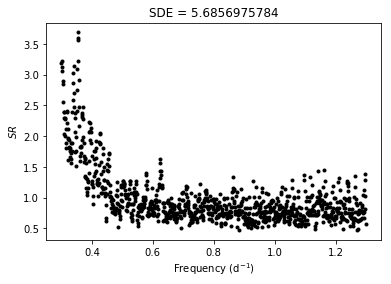

In [31]:
freq = np.arange(0.3, 1.3, 0.001)
plt.plot(freq, res[7], 'k.')
plt.title("SDE = {0}".format(res[6]))
plt.xlabel(r"Frequency (d$^{-1}$)")
plt.ylabel(r"$SR$")

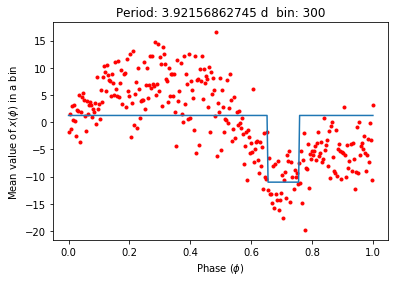

In [32]:
t1 = t[0]
u = t - t1
s = np.mean(f)
v = f - s

f0 = 1.0/res[5] #  freq = 1/T
nbin = nb # number of bin
n = len(t)
ibi = np.zeros(nbin)
y = np.zeros(nbin)
phase = np.linspace(0.0, 1.0, nbin)

for i in range(n):
    ph = u[i]*f0 
    ph = ph - int(ph)
    j = int(nbin*ph) # data to a bin 
    ibi[j] = ibi[j] + 1.0 # number of data in a bin
    y[j] = y[j] + v[i] # sum of light in a bin


plt.plot(phase, y/ibi, 'r.')
fite = np.zeros(nbin) + res[8] # H
fite[res[1]:res[2]+1] = res[9] # L
    
plt.plot(phase, fite)
plt.title("Period: {0} d  bin: {1}".format(1/f0, nbin))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

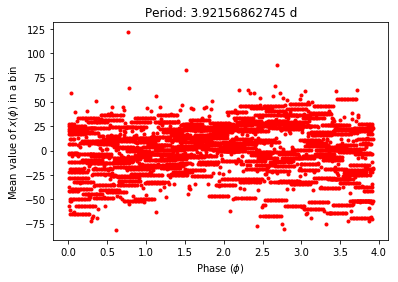

In [33]:
T0 = res[5]
n = len(t)
y = np.zeros(n)
y = t % T0

plt.plot(y, v, 'r.')
plt.title("Period: {0} d".format(1/f0))
plt.xlabel(r"Phase ($\phi$)")
plt.ylabel(r"Mean value of $x(\phi)$ in a bin")

# Ignore Everything Below Here

In [ ]:
# #using pyfits to open a quarter of data as .fits file
# pyfits.open('c:/Users/rscsa/.kplr/data/lightcurves/010874614/kplr010874614-2009131105131_llc.fits')
# print pyfits.hdu.image.PrimaryHDU()